In [1]:
%%vertica
SELECT 'Connected to Vertica'

,?column?
0,Connected to Vertica


In [2]:
import datetime
from dateutil.tz import tzutc

exclude_course_ids = (
    'course-v1:IIMBx+AC103x+2T2017',
    'course-v1:AdelaideX+Project101x+1T2017',
    'course-v1:DelftX+LfE101x+2T2017',
    'course-v1:ColumbiaX+DS101X+1T2017',
    'course-v1:PennX+SD2x+2T2017',
    'course-v1:PennX+SD1x+2T2017',
    'course-v1:HarvardX+PH525.1x+2T2017',
    'course-v1:MichiganX+UX501x+3T2016',
    'course-v1:UBCx+Marketing1x+3T2015',
    'course-v1:DelftX+CTB3365DWx+2T2017',
)
experiment_id = 8
experiment_start = datetime.datetime(2017, 8, 2, 11, 0, tzinfo=tzutc())

In [3]:
%%vertica
SELECT
    MAX(first_verified_enrollment_time)
FROM
    production.d_user_course

,MAX
0,2017-09-16 23:52:07.015711


In [4]:
%%vertica (experiment_start, experiment_id, exclude_course_ids) -> conversions

-- This query should return one record per enrollment.
SELECT
    ee.user_id,
    ee.course_id,
    ee.group_name,
    ee.cohort_availability_date,
    duc.first_verified_enrollment_time,
    COALESCE(duc.first_verified_enrollment_time >= ee.exposure_time, false) AS verified_after_exposure,
    COALESCE(duc.first_verified_enrollment_time >= ee.cohort_availability_date, false) AS verified_after_cohort_availability,
    duc.verified,
    duc.gross_bookings
FROM
(
    SELECT
        user_id,
        SUBSTRING(key FROM 26) AS course_id,
        CASE MAPLOOKUP(MAPJSONEXTRACTOR(value), 'segment')
            WHEN 0 THEN 'Control'
            WHEN 1 THEN 'Hard Deadline'
            WHEN 2 THEN 'Soft Deadline'
        END AS group_name,
        MAPLOOKUP(MAPJSONEXTRACTOR(value), 'cohort_availability')::DATE AS cohort_availability_date,
        created AS exposure_time
    FROM
        lms_read_replica.experiments_experimentdata
    WHERE
        experiment_id = :experiment_id
    ORDER BY 1, 2
) ee

JOIN
(
    SELECT
        uc.user_id,
        uc.course_id,
        uc.first_verified_enrollment_time,
        CASE WHEN uc.first_verified_enrollment_time IS NOT NULL THEN cm.course_seat_price ELSE 0 END AS gross_bookings,
        uc.first_verified_enrollment_time IS NOT NULL AS verified
    FROM
        production.d_user_course uc
    JOIN
        business_intelligence.course_master cm ON cm.course_id = uc.course_id
    ORDER BY 1, 2
) duc
ON
    duc.user_id = ee.user_id
    AND duc.course_id = ee.course_id
WHERE
    ee.course_id NOT IN :exclude_course_ids
    AND ee.cohort_availability_date = CAST(:experiment_start AS DATE)

In [5]:
conversions.groupby(['group_name']).verified.value_counts()

group_name     verified
Control        False       31652
               True          494
Hard Deadline  False       31324
               True          635
Soft Deadline  False       32031
               True          673
Name: verified, dtype: int64

In [6]:
conversions['variation'] = conversions.group_name.apply(lambda g: g if g == 'Control' else 'Treatment')

In [7]:
a = conversions.groupby(['user_id', 'course_id']).size()
assert len(a[a > 1]) == 0, 'There should be exactly one record per enrollment'

In [8]:
totals = conversions.groupby('variation').verified.count()
converted = conversions.groupby('variation').verified.sum()

print(totals)
print(converted)
converted / totals

variation
Control      32146
Treatment    64663
Name: verified, dtype: int64
variation
Control       494.0
Treatment    1308.0
Name: verified, dtype: float64


variation
Control      0.015367
Treatment    0.020228
Name: verified, dtype: float64

In [9]:
totals = conversions.groupby('variation').verified_after_cohort_availability.count()
converted = conversions.groupby('variation').verified_after_cohort_availability.sum()

print(totals)
print(converted)
converted / totals

variation
Control      32146
Treatment    64663
Name: verified_after_cohort_availability, dtype: int64
variation
Control       493.0
Treatment    1308.0
Name: verified_after_cohort_availability, dtype: float64


variation
Control      0.015336
Treatment    0.020228
Name: verified_after_cohort_availability, dtype: float64

In [10]:
import edx_stats
import edx_plot
from plotnine import *
from IPython.display import display

def compute(df, variant_col, value_col, title):
    conversions_conf_intervals = edx_stats.grouped_confidence_intervals(
        df.reset_index(),
        variant_col=variant_col,
        value_col=value_col,
        ctrl_name='Control',
    )
    display(
        ggplot(conversions_conf_intervals.reset_index(), aes(
            x=variant_col,
            y='percent_change',
            ymin='lower_bound',
            ymax='upper_bound',
            color='significant',
            label_size=0.5,
        ))
        + edx_plot.geom_confidence()
        + edx_plot.theme_confidence()
        + ggtitle(title)
    )
    return conversions_conf_intervals

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


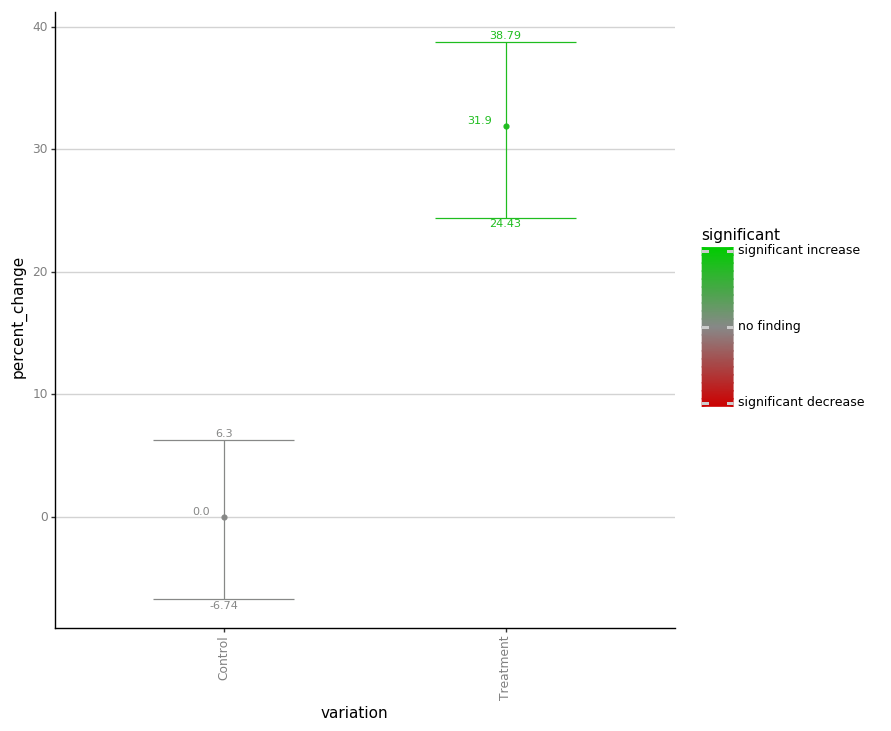

<ggplot: (-9223363280407100458)>

,lower_bound,percent_change,upper_bound,significant
variation,,,,
Control,-6.735016,0.000000,6.299213,0.000000
Treatment,24.425459,31.896088,38.785799,0.765782


In [11]:
compute(
    conversions,
    'variation',
    'verified_after_cohort_availability',
    ''
)

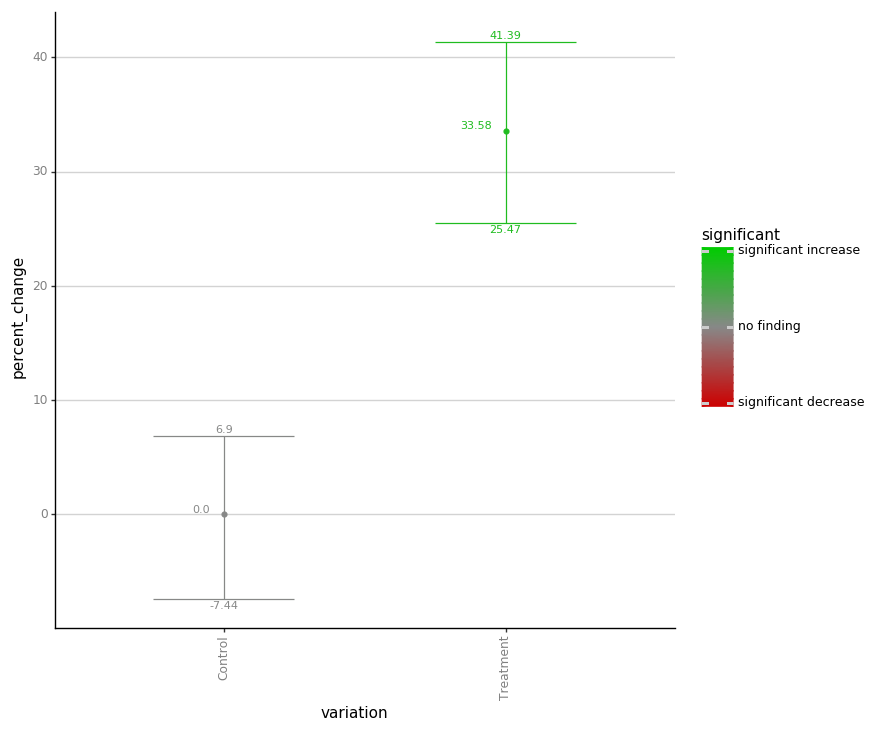

<ggplot: (8756501129252)>

,lower_bound,percent_change,upper_bound,significant
variation,,,,
Control,-7.435819,0.000000,6.896364,0.000000
Treatment,25.468141,33.580172,41.387254,0.758428


In [12]:
compute(
    conversions,
    'variation',
    'gross_bookings',
    ''
)

In [13]:
%%vertica -> end_of_duc
SELECT
    end_time
FROM
    production.d_user_course duc
LIMIT 1

In [14]:
max_enroll_date = end_of_duc.loc[0].end_time

In [15]:
%%vertica (experiment_start, experiment_id, exclude_course_ids, max_enroll_date) -> audit_duration_counts

SELECT
    exp.group_name IS NULL AS is_baseline,
    CASE
        WHEN exp.group_name IS NOT NULL THEN exp.group_name || '_' || exp.cohort_availability_date
        ELSE c.pacing_type || '_baseline'
    END AS variation_name,
    CASE
        WHEN duc.first_verified_enrollment_time IS NULL THEN DATEDIFF('day', duc.content_availability_date, :max_enroll_date)
        ELSE DATEDIFF('day', duc.content_availability_date, duc.first_verified_enrollment_time)
    END AS duration,
    duc.first_verified_enrollment_time IS NOT NULL AS verified,
    COUNT(*) AS cnt_users
FROM
    business_intelligence.user_content_availability_date duc
JOIN business_intelligence.course_master AS c ON c.course_id = duc.course_id
JOIN production.d_user AS du ON du.user_id = duc.user_id
LEFT JOIN
(
    SELECT
        user_id,
        SUBSTRING(key FROM 26) AS course_id,
        CASE MAPLOOKUP(MAPJSONEXTRACTOR(value), 'segment')
            WHEN 0 THEN 'Control'
            WHEN 1 THEN 'Hard_Deadline'
            WHEN 2 THEN 'Soft_Deadline'
        END AS group_name,
        MAPLOOKUP(MAPJSONEXTRACTOR(value), 'cohort_availability')::DATE AS cohort_availability_date,
        created AS exposure_time
    FROM
        lms_read_replica.experiments_experimentdata
    WHERE
        experiment_id = :experiment_id
        AND SUBSTRING(key FROM 26) NOT IN :exclude_course_ids
        AND MAPLOOKUP(MAPJSONEXTRACTOR(value), 'cohort_availability')::DATE = CAST(:experiment_start AS DATE)
) exp ON exp.user_id = duc.user_id AND exp.course_id = duc.course_id
WHERE
    -- only include enrollments that occurred after the course started and before the verification deadline
    duc.content_availability_date <= c.course_verification_end_date
    AND du.user_email NOT LIKE '%@edx.org'
    AND c.course_partner != 'Microsoft'
    
    AND (
        -- segmentation ensures that you only have a row in the experimentdata table iff you are in the
        -- experiment
        exp.group_name IS NOT NULL
        OR
        -- for all others, just use recent enrollments
        duc.content_availability_date > '2017-04-01'
    )
GROUP BY 1, 2, 3, 4
ORDER BY 1, 4, 2, 3

In [16]:
import pandas as pd
import itertools
def explode_dataframe(df, count_col='cnt_users'):
    """
    Convert a dataframe with counts in ``count_col``
    into a dataframe with ``count_col`` copies of each row.
    """
    
    non_counted_columns = df.columns[df.columns != count_col]
    
    def duplicate_row(row):
        row_tuple = tuple(row[non_counted_columns])
        for _ in range(row[count_col]):
            yield row_tuple
                          
    return pd.DataFrame(
        list(itertools.chain.from_iterable(
            duplicate_row(row) for
            _, row in df.iterrows()
        )),
        columns=non_counted_columns
    )

In [17]:
import pandas as pd
from lifelines import KaplanMeierFitter

plot_num = 0
all_enrollees = pd.DataFrame(columns=['ts', 'ps', 'ps_hi', 'ps_lo', 'is_baseline', 'variation_name'])
        
kmf = KaplanMeierFitter()

for key, group in audit_duration_counts.groupby(
    ['is_baseline', 'variation_name']
):
    is_baseline, variation_name = key

    exploded_group = explode_dataframe(group)
    kmf.fit(exploded_group.duration, event_observed=exploded_group.verified)
    del exploded_group

    ts = kmf.survival_function_.index.values
    ps = 1.0 - kmf.survival_function_['KM_estimate'].values
    ps_hi = 1.0 - kmf.confidence_interval_['KM_estimate_lower_0.95'].values
    ps_lo = 1.0 - kmf.confidence_interval_['KM_estimate_upper_0.95'].values

    all_enrollees = all_enrollees.append(pd.DataFrame({
        'ts': ts,
        'ps': ps,
        'ps_hi': ps_hi,
        'ps_lo': ps_lo,
        'is_baseline': is_baseline,
        'variation_name': variation_name,
    }, columns=all_enrollees.columns))

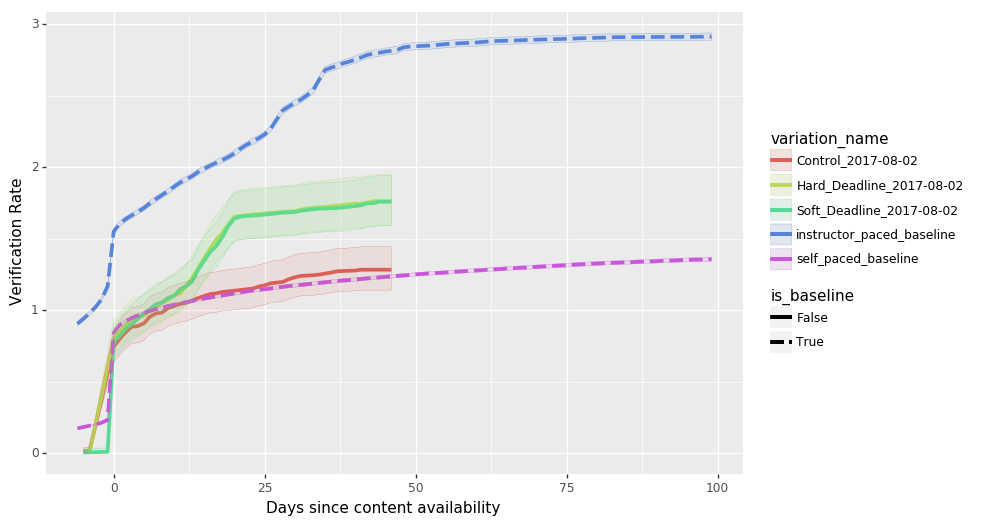

<ggplot: (8756447002544)>

In [18]:
from plotnine import *

df_filter = (all_enrollees.ts < 100) & (all_enrollees.ts > -7)
    

display(
    ggplot(all_enrollees[df_filter].dropna(), aes(
        x='ts',
        y='ps * 100',
        ymin='ps_lo * 100',
        ymax='ps_hi * 100',
        color='variation_name',
        fill='variation_name',
    ))
    + geom_line(aes(linetype='is_baseline'), size=1.5)
    + geom_ribbon(alpha=0.1, size=0.1)
    + xlab('Days since content availability')
    + ylab('Verification Rate')
    + theme(figure_size=(9, 6))
)